## Example for FloPy methods note

Import the `modflow` and `utils` subpackages of FloPy and give them the aliases `fpm` and `fpu`, respectively

In [1]:
import os
import sys
import numpy as np
import matplotlib as mpl

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join("..", "..", ".."))
    sys.path.append(fpth)
    import flopy

import flopy.modflow as fpm
import flopy.utils as fpu


print(sys.version)
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))
print("flopy version: {}".format(flopy.__version__))

3.10.5 (v3.10.5:f377153967, Jun  6 2022, 12:36:10) [Clang 13.0.0 (clang-1300.0.29.30)]
numpy version: 1.23.1
matplotlib version: 3.5.2
flopy version: 3.3.6


Create a MODFLOW model object. Here, the MODFLOW model object is stored in a Python variable called {\tt model}, but this can be an arbitrary name. This object name is important as it will be used as a reference to the model in the remainder of the FloPy script. In addition, a {\tt modelname} is specified when the MODFLOW model object is created. This {\tt modelname} is used for all the files that are created by FloPy for this model.

In [2]:
exe = "mf2005"
ws = os.path.join("temp")
model = fpm.Modflow(modelname="gwexample", exe_name=exe, model_ws=ws)

The discretization of the model is specified with the discretization file (DIS) of MODFLOW. The aquifer is divided into 201 cells of length 10 m and width 1 m.  The first input of the discretization package is the name of the model object. All other input arguments are self explanatory.

In [3]:
fpm.ModflowDis(
    model, nlay=1, nrow=1, ncol=201, delr=10, delc=1, top=50, botm=0
)


    MODFLOW Discretization Package Class.

    Parameters
    ----------
    model : model object
        The model object (of type :class:`flopy.modflow.Modflow`) to which
        this package will be added.
    nlay : int
        Number of model layers (the default is 1).
    nrow : int
        Number of model rows (the default is 2).
    ncol : int
        Number of model columns (the default is 2).
    nper : int
        Number of model stress periods (the default is 1).
    delr : float or array of floats (ncol), optional
        An array of spacings along a row (the default is 1.0).
    delc : float or array of floats (nrow), optional
        An array of spacings along a column (the default is 0.0).
    laycbd : int or array of ints (nlay), optional
        An array of flags indicating whether or not a layer has a Quasi-3D
        confining bed below it. 0 indicates no confining bed, and not zero
        indicates a confining bed. LAYCBD for the bottom layer must be 0. (the
    

Active cells and the like are defined with the Basic package (BAS), which is required for every MODFLOW model. It contains the {\tt ibound} array, which is used to specify which cells are active (value is positive), inactive (value is 0), or fixed head (value is negative). The {\tt numpy} package (aliased as {\tt np}) can be used to quickly initialize the {\tt ibound} array with values of 1, and then set the {\tt ibound} value for the first and last columns to -1. The {\tt numpy} package (and Python, in general) uses zero-based indexing and supports negative indexing so that row 1 and column 1, and row 1 and column 201, can be referenced as [0, 0], and [0, -1], respectively.  Although this simulation is for steady flow, starting heads still need to be specified. They are used as the head for fixed-head cells (where {\tt ibound} is negative), and as a starting point to compute the saturated thickness for cases of unconfined flow. 

In [4]:
ibound = np.ones((1, 201))
ibound[0, 0] = ibound[0, -1] = -1
fpm.ModflowBas(model, ibound=ibound, strt=20)


    MODFLOW Basic Package Class.

    Parameters
    ----------
    model : model object
        The model object (of type :class:`flopy.modflow.mf.Modflow`) to which
        this package will be added.
    ibound : array of ints, optional
        The ibound array (the default is 1).
    strt : array of floats, optional
        An array of starting heads (the default is 1.0).
    ifrefm : bool, optional
        Indication if data should be read using free format (the default is
        True).
    ixsec : bool, optional
        Indication of whether model is cross sectional or not (the default is
        False).
    ichflg : bool, optional
        Flag indicating that flows between constant head cells should be
        calculated (the default is False).
    stoper : float
        percent discrepancy that is compared to the budget percent discrepancy
        continue when the solver convergence criteria are not met.  Execution
        will unless the budget percent discrepancy is greate

The hydraulic properties of the aquifer are specified with the Layer Properties Flow (LPF) package (alternatively, the Block Centered Flow (BCF) package may be used). Only the hydraulic conductivity of the aquifer and the layer type ({\tt laytyp}) need to be specified. The latter is set to 1, which means that MODFLOW will calculate the saturated thickness differently depending on whether or not the head is above the top of the aquifer.


In [5]:
fpm.ModflowLpf(model, hk=10, laytyp=1)


    MODFLOW Layer Property Flow Package Class.

    Parameters
    ----------
    model : model object
        The model object (of type :class:`flopy.modflow.mf.Modflow`) to which
        this package will be added.
    ipakcb : int
        A flag that is used to determine if cell-by-cell budget data should be
        saved. If ipakcb is non-zero cell-by-cell budget data will be saved.
        (default is 0)
    hdry : float
        Is the head that is assigned to cells that are converted to dry during
        a simulation. Although this value plays no role in the model
        calculations, it is useful as an indicator when looking at the
        resulting heads that are output from the model. HDRY is thus similar
        to HNOFLO in the Basic Package, which is the value assigned to cells
        that are no-flow cells at the start of a model simulation.
        (default is -1.e30).
    laytyp : int or array of ints (nlay)
        Layer type, contains a flag for each layer that spe

Aquifer recharge is simulated with the Recharge package (RCH) and the extraction of water at the two ditches is simulated with the Well package (WEL). The latter requires specification of the layer, row, column, and injection rate of the well for each stress period. The layers, rows, columns, and the stress period are numbered (consistent with Python's zero-based numbering convention) starting at 0. The required data are stored in a Python dictionary ({\tt lrcQ} in the code below), which is used in FloPy to store data that can vary by stress period. The {\tt lrcQ} dictionary specifies that two wells (one in cell 1, 1, 51 and one in cell 1, 1, 151), each with a rate of -1 m$^3$/m/d, will be active for the first stress period.  Because this is a steady-state model, there is only one stress period and therefore only one entry in the dictionary.

In [6]:
fpm.ModflowRch(model, rech=0.001)
lrcQ = {0: [[0, 0, 50, -1], [0, 0, 150, -1]]}
fpm.ModflowWel(model, stress_period_data=lrcQ)


    MODFLOW Well Package Class.

    Parameters
    ----------
    model : model object
        The model object (of type :class:`flopy.modflow.mf.Modflow`) to which
        this package will be added.
    ipakcb : int
        A flag that is used to determine if cell-by-cell budget data should be
        saved. If ipakcb is non-zero cell-by-cell budget data will be saved.
        (default is 0).
    stress_period_data : list of boundaries, or recarray of boundaries, or
        dictionary of boundaries
        Each well is defined through definition of
        layer (int), row (int), column (int), flux (float).
        The simplest form is a dictionary with a lists of boundaries for each
        stress period, where each list of boundaries itself is a list of
        boundaries. Indices of the dictionary are the numbers of the stress
        period. This gives the form of:

            stress_period_data =
            {0: [
                [lay, row, col, flux],
                [lay, r

The Preconditioned Conjugate-Gradient (PCG) solver, using the default settings, is specified to solve the model.

In [7]:
fpm.ModflowPcg(model)


    MODFLOW Pcg Package Class.

    Parameters
    ----------
    model : model object
        The model object (of type :class:`flopy.modflow.mf.Modflow`) to which
        this package will be added.
    mxiter : int
        maximum number of outer iterations. (default is 50)
    iter1 : int
        maximum number of inner iterations. (default is 30)
    npcond : int
        flag used to select the matrix conditioning method. (default is 1).
        specify npcond = 1 for Modified Incomplete Cholesky.
        specify npcond = 2 for Polynomial.
    hclose : float
        is the head change criterion for convergence. (default is 1e-5).
    rclose : float
        is the residual criterion for convergence. (default is 1e-5)
    relax : float
        is the relaxation parameter used with npcond = 1. (default is 1.0)
    nbpol : int
        is only used when npcond = 2 to indicate whether the estimate of the
        upper bound on the maximum eigenvalue is 2.0, or whether the estimate
    

The frequency and type of output that MODFLOW writes to an output file is specified with the Output Control (OC) package.  In this case, the budget is printed and heads are saved (the default), so no arguments are needed.

In [8]:
fpm.ModflowOc(model)


    MODFLOW Output Control Package Class.

    Parameters
    ----------
    model : model object
        The model object (of type :class:`flopy.modflow.mf.Modflow`) to which
        this package will be added.
    ihedfm : int
        is a code for the format in which heads will be printed.
        (default is 0).
    iddnfm : int
        is a code for the format in which drawdown will be printed.
        (default is 0).
    chedfm : string
        is a character value that specifies the format for saving heads.
        The format must contain 20 characters or less and must be a valid
        Fortran format that is enclosed in parentheses. The format must be
        enclosed in apostrophes if it contains one or more blanks or commas.
        The optional word LABEL after the format is used to indicate that
        each layer of output should be preceded with a line that defines the
        output (simulation time, the layer being output, and so forth). If
        there is no record 

Finally the MODFLOW input files are written (eight files for this model) and the model is run. This requires, of course, that MODFLOW is installed on your computer and FloPy can find the executable in your path.

In [9]:
model.write_input()
model.run_model()

FloPy is using the following executable to run the model: /Users/wes/dev/usgs-executables/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: gwexample.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/07/30 16:21:52

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/07/30 16:21:52
 Elapsed run time:  0.003 Seconds

  Normal termination of simulation


(True, [])

After MODFLOW has responded with the positive {\tt Normal termination of simulation}, the calculated heads can be read from the binary output file. First a file object is created. As the modelname used for all MODFLOW files was specified as {\tt gwexample} in step 1, the file with the heads is called {\tt gwexample.hds}. FloPy includes functions to read data from the file object, including heads for specified layers or time steps, or head time series at individual cells. For this simple mode, all computed heads are read.

In [10]:
fpth = os.path.join(ws, "gwexample.hds")
hfile = fpu.HeadFile(fpth)
h = hfile.get_data(totim=1.0)

The heads are now stored in the Python variable {\tt h}. FloPy includes powerful plotting functions to plot the grid, boundary conditions, head, etc. This functionality is demonstrated later. For this simple one-dimensional example, a plot is created with the matplotlib package

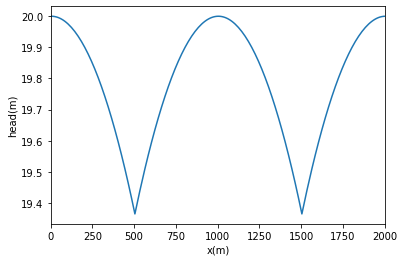

In [11]:
import matplotlib.pyplot as plt

ax = plt.subplot(111)
x = model.modelgrid.xcellcenters[0]
ax.plot(x, h[0, 0, :])
ax.set_xlim(0, x.max())
ax.set_xlabel("x(m)")
ax.set_ylabel("head(m)")
plt.show()